In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


### Import dataset

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

r = pd.read_csv('/content/gdrive/MyDrive/RecSys Project 2/goodbooks-10k-dataset/ratings.csv')  
tr = pd.read_csv('/content/gdrive/MyDrive/RecSys Project 2/goodbooks-10k-dataset/to_read.csv')
b = pd.read_csv('/content/gdrive/MyDrive/RecSys Project 2/goodbooks-10k-dataset/books.csv')
t = pd.read_csv('/content/gdrive/MyDrive/RecSys Project 2/goodbooks-10k-dataset/tags.csv')
bt = pd.read_csv('/content/gdrive/MyDrive/RecSys Project 2/goodbooks-10k-dataset/book_tags.csv')

In [7]:
n_users = r.user_id.nunique()
n_items = r.book_id.nunique()
n_ratings = len(r)
rating_matrix_size = n_users * n_items
sparsity = 1 - n_ratings / rating_matrix_size

print(f"Number of users: {n_users}")
print(f"Number of items: {n_items}")
print(f"Number of available ratings: {n_ratings}")
print(f"Number of all possible ratings: {rating_matrix_size}")
print("-" * 40)
print(f"SPARSITY: {sparsity * 100.0:.2f}%")

Number of users: 53424
Number of items: 10000
Number of available ratings: 5976479
Number of all possible ratings: 534240000
----------------------------------------
SPARSITY: 98.88%


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of Ratings')

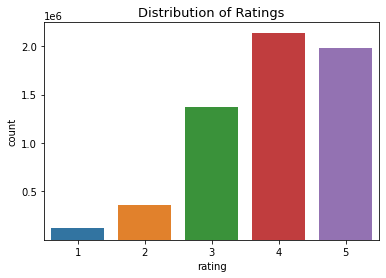

In [15]:
plt.figure(figsize=(6, 4))
sns.countplot(r['rating'])
plt.yticks([500000, 1000000, 1500000, 2000000])
plt.title('Distribution of Ratings', fontsize=13)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

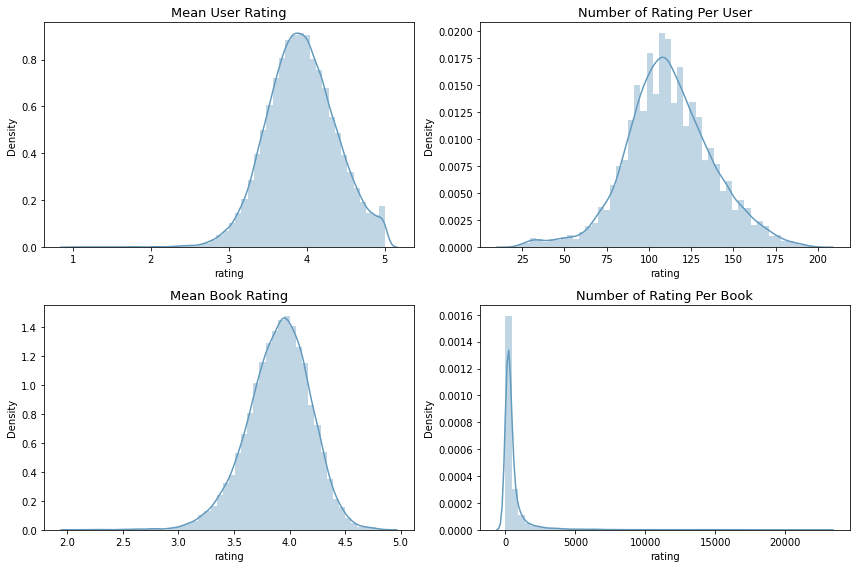

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

sns.distplot(r.groupby('user_id').mean()['rating'], color='#639abd', ax=ax[0][0])
ax[0][0].set_title('Mean User Rating', fontsize=13)

sns.distplot(r.groupby('user_id').count()['rating'].sort_values(ascending=False), 
             color='#639abd', ax=ax[0][1])
ax[0][1].set_title('Number of Rating Per User', fontsize=13)

sns.distplot(r.groupby('book_id').mean()['rating'], color='#639abd', ax=ax[1][0])
ax[1][0].set_title('Mean Book Rating', fontsize=13)

sns.distplot(r.groupby('book_id').count()['rating'].sort_values(ascending=False), 
             color='#639abd', ax=ax[1][1])
ax[1][1].set_title('Number of Rating Per Book', fontsize=13)

plt.tight_layout()
plt.show()

### Preprossing
filter tags to be book genres

In [33]:
tag_number = bt.groupby('goodreads_book_id').nunique()['tag_id'].mean()
print(f'Unique genre number: {len(t)}')
print(f'Average tag number: {tag_number}')

Unique genre number: 34252
Average tag number: 99.9904


In [10]:
genre = ['art', 'biography', 'business', 'chick lit', "children's",
         'christian', 'classics', 'comics', 'contemporary', 'cookbooks',
         'crime', 'young adult', 'fantasy', 'fiction', 'gay and lesbian',
         'graphic novels', 'history', 'horror', 'humor and comedy', 
         'manga', 'memoir', 'music', 'mystery', 'nonfiction', 'paranormal', 
         'philosophy', 'poetry', 'psychology', 'religion', 'romance', 'science', 
         'self help', 'suspense', 'spirituality', 'sports', 'thriller', 'travel']

In [25]:
def func(genre):
    tag = pd.DataFrame()

    for _ in genre:
        df = t[t['tag_name'].str.replace(r'\W+', ' ').str.contains(rf"\b{_}\b")]
        df['genre'] = _
        tag = pd.concat([tag, df])
        
    df = pd.merge(bt, tag, on='tag_id')
    tag_number = df.groupby('goodreads_book_id').nunique()['genre'].mean()
    
    print(f'Unique genre number: {len(genre)}')
    print(f'Average tag number: {tag_number}')
    
    df = df[['goodreads_book_id', 'genre']].drop_duplicates()
    df = pd.merge(df, b[['goodreads_book_id', 'book_id']], on='goodreads_book_id')[['book_id', 'genre']]
    bookid_number = len(df['book_id'].unique())
    print(f'Unique book id number with tags: {bookid_number}')
    return df

def genre_countplot(df):
    df['count'] = 1
    df = df.pivot_table(index='book_id', columns='genre', values='count', fill_value=None)
    df.sum().sort_values().plot(kind='barh', figsize=(12, 18))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Unique genre number: 37
Average tag number: 6.4795
Unique book id number with tags: 10000


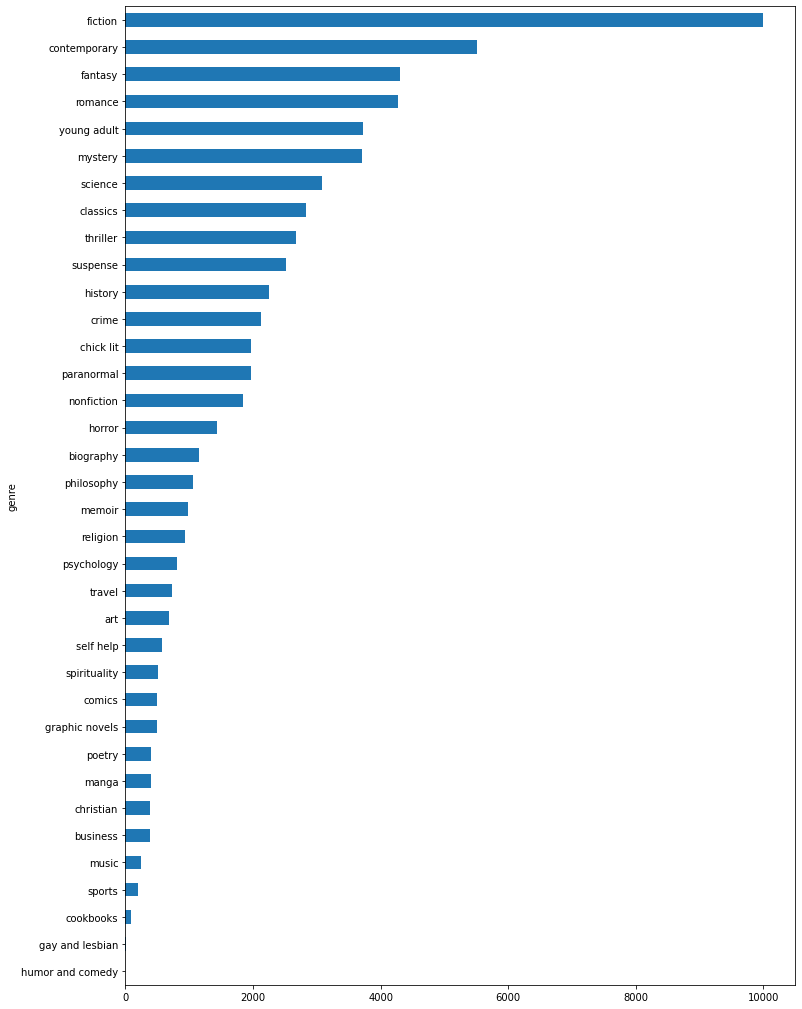

In [26]:
df = func(genre)
genre_countplot(df)

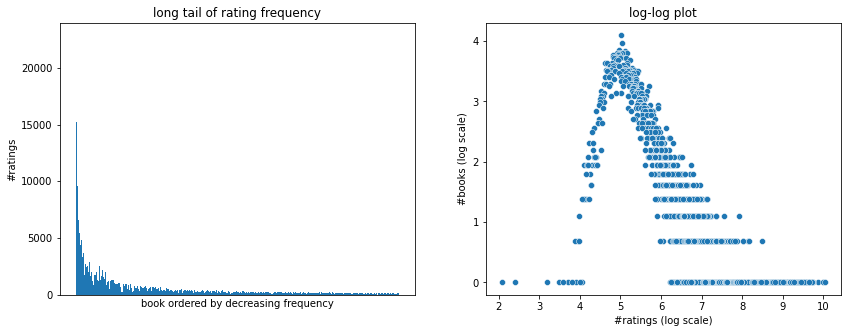

In [36]:
book_rate_count = r.groupby('book_id')['user_id'].nunique().sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axes[0].bar(x=book_rate_count.index, height=book_rate_count.values, width=1.0, align="edge")
axes[0].set_xticks([])
axes[0].set(title="long tail of rating frequency", 
            xlabel="book ordered by decreasing frequency", 
            ylabel="#ratings")

count = book_rate_count.value_counts()
sns.scatterplot(x=np.log(count.index), y=np.log(count.values), ax=axes[1])
axes[1].set(title="log-log plot", xlabel="#ratings (log scale)", ylabel="#books (log scale)");

In [60]:
!pip install --quiet cornac

In [61]:
from collections import defaultdict
from sklearn.model_selection import train_test_split
import cornac
from cornac.utils import cache

print(f"Cornac version: {cornac.__version__}")

SEED = 42  # @param 
VERBOSE = False  # @param 

Cornac version: 1.6.1


# Modeling
### Baseline - Most popular

In [40]:
# 3-fold cross validation
eval_method = cornac.eval_methods.CrossValidation(np.array(r), n_folds=3, seed=42)

# recommender system based on item popularity
most_pop = cornac.models.MostPop()

eval_metrics = [
      cornac.metrics.RMSE(), 
      cornac.metrics.AUC(),
      cornac.metrics.Precision(k=20),
      cornac.metrics.Recall(k=20),
      cornac.metrics.FMeasure(k=20),
      cornac.metrics.NDCG(k=20),
      cornac.metrics.NCRR(k=20)
]

# put everything together into an experiment
cornac.Experiment(eval_method=eval_method, models=[most_pop], metrics=eval_metrics).run()


TEST:
...
[MostPop]
       |   RMSE | NCRR@20 | NDCG@20 | Precision@20 | Recall@20 | Train (s) | Test (s)
------ + ------ + ------- + ------- + ------------ + --------- + --------- + --------
Fold 0 | 1.3885 |  0.1178 |  0.1084 |       0.1008 |    0.0544 |    0.2908 | 119.4390
Fold 1 | 1.3875 |  0.1176 |  0.1082 |       0.1007 |    0.0544 |    0.2764 | 120.7020
Fold 2 | 1.3873 |  0.1177 |  0.1083 |       0.1007 |    0.0545 |    0.2726 | 118.6686
------ + ------ + ------- + ------- + ------------ + --------- + --------- + --------
Mean   | 1.3878 |  0.1177 |  0.1083 |       0.1007 |    0.0544 |    0.2799 | 119.6032
Std    | 0.0005 |  0.0001 |  0.0001 |       0.0001 |    0.0001 |    0.0078 |   0.8382



In [ ]:
!./libfm/bin/libFM -task r -method 'als' -train train.libfm -test test.libfm -seed $SEED -dim "1,1,10" -iter 100 -out output.libfm -save_model model.libfm